In [1]:
%matplotlib notebook

import numpy as np
import cv2
from glob import glob
from PIL import Image
from ipywidgets import interact, fixed, IntSlider
from matplotlib import pyplot as plt
from itertools import islice

In [2]:
def show_images(images):
    fig = plt.figure()
    for i in range(len(images)):
        img = images[i]
        a = fig.add_subplot(1, len(images), i + 1)
        plt.imshow(img, cmap=(None if len(img.shape) == 3 else 'gray'))
        #plt.axis('off')
    plt.show()

def show_rgb(img):
    show_images([img])
    
def show_hsv(images):
    show_images(cv2.cvtColor(img, cv2.COLOR_HSV2RGB) for img in images)

def show_gray(images):
    show_images(images)

<IPython.core.display.Javascript object>


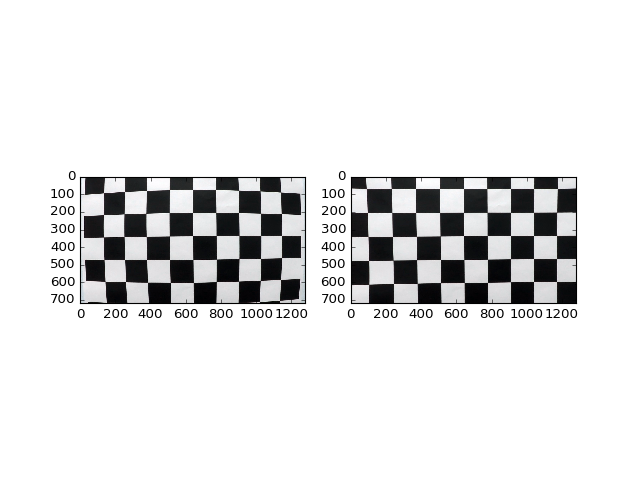

<IPython.core.display.Javascript object>


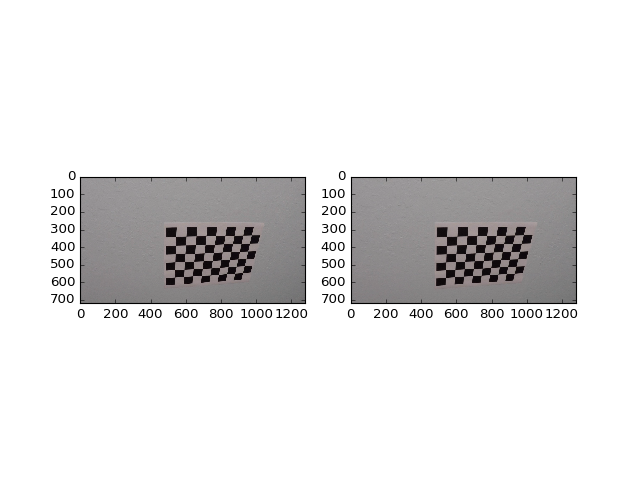

In [3]:
chess_shape = (9, 6)
objpoints = []
imgpoints = []
objp = np.zeros((6*9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1, 2)
for path in glob('camera_cal/*'):
    img = cv2.imread(path) 
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, chess_shape, None)
    
    if ret:
        imgpoints.append(corners)
        objpoints.append(objp)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

for path in islice(glob('camera_cal/*'), 2):
    img = cv2.imread(path)
    dst = undistort(img)
    show_images([img, dst])

<IPython.core.display.Javascript object>


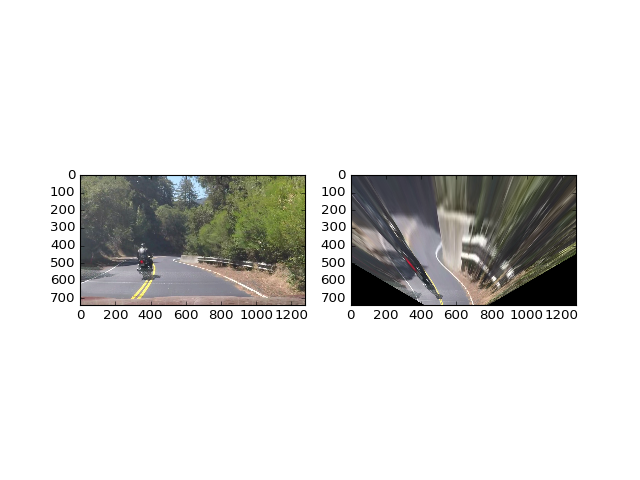

<IPython.core.display.Javascript object>


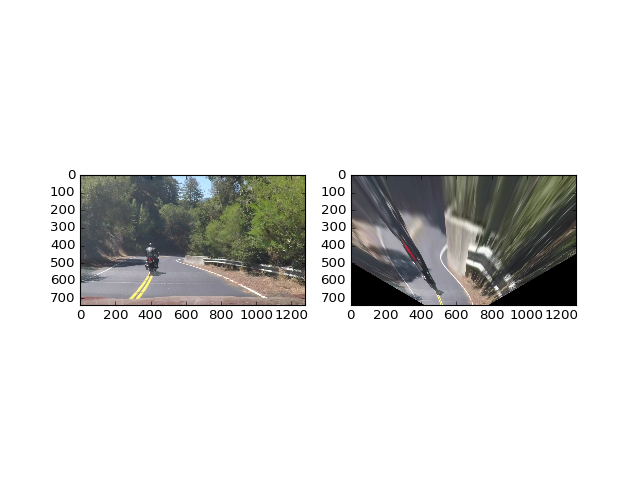

In [4]:
src = np.float32([
        [253, 685],
        [572, 465],
        [709, 465],
        [1052, 685]])

dst = np.float32([
        [500, 750],
        [500, 300],
        [700, 300],
        [700, 750]])

M = cv2.getPerspectiveTransform(src, dst)

def get_road(img):
    img_size = (img.shape[1], img.shape[0])
    # we mostly are interested in upscaling and CUBIC seems to be quite good
    # http://tanbakuchi.com/posts/comparison-of-openv-interpolation-algorithms/
    return cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_CUBIC)
    
for i in islice(glob('test_images2/*'), 2):
    img = np.asarray(Image.open(i))
    road = get_road(img)
    show_images([img, road])


In [ ]:
#points = np.random.random((10, 2))
pp = []
for p in [[5, 1], [4, 3], [4.5, 2.5], [4.7, 2.3], [3.9, 2]]:
    for i in range(10):
        pp.append([p[0]+np.random.random()*0.4, p[1]+np.random.random()*0.4])
        
points = np.array(pp)

x = points[:, 0]
y = points[:, 1]

residuals, rank, singular_values, rcond, pre = np.polyfit(y, x, 10, full=True)
print("residuals: %s" % residuals)
print("rank: %s" % rank)
print("singular_values: %s" % singular_values)
print("rcond: %s" % rcond)
print("pre: %s" % pre)

f = np.poly1d(residuals, variable='y')
print(f)

y_new = np.linspace(min(y), max(y), 50)
x_new = f(y_new)

plt.figure()
plt.margins(0.1, 0.1)
plt.plot(x, y, '.', x_new, y_new)
plt.show()

Processing row 0
Processing row 1
Processing row 2
Processing row 3
Processing row 4
Processing row 5
Processing row 6
Processing row 7
Processing row 8
Processing row 9
Processing row 10
Processing row 11
Processing row 12
Processing row 13
Processing row 14
Processing row 15
Processing row 16
Processing row 17
Processing row 18
Processing row 19
Processing row 20
Processing row 21
Processing row 22
Processing row 23
Processing row 24
Processing row 25
Processing row 26
Processing row 27
Processing row 28
Processing row 29
Processing row 0
Processing row 1
Processing row 2
Processing row 3
Processing row 4
Processing row 5
Processing row 6
Processing row 7
Processing row 8
Processing row 9
Processing row 10
Processing row 11
Processing row 12
Processing row 13
Processing row 14
Processing row 15
Processing row 16
Processing row 17
Processing row 18
Processing row 19
Processing row 20
Processing row 21
Processing row 22
Processing row 23
Processing row 24
Processing row 25
Processing r

<IPython.core.display.Javascript object>


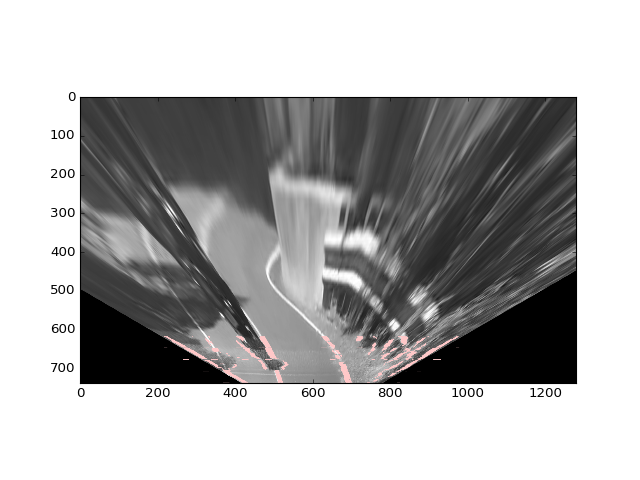

In [29]:
def find_lane_yellow_mask(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h = hsv[:,:,0]
    s = hsv[:,:,1]
    v = hsv[:,:,v]
    mask = np.zeros_like(h)
    mask[(h > 15) & (h <= 31)] = 1
    return mask
    
def find_lane_gray_mask(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    mask = np.zeros_like(gray)
    mask[gray >= 225] = 1
    return mask

class Line():
    def __init__(self):
        self.pixels = []
        self.minx = 10000
        self.maxx = 0
        
    def could_contain_pixel(self, p):
        max_distance = 2
        if (self.minx - max_distance < p[1] < self.maxx + max_distance and 
             abs(p[0] - self.pixels[-1][0]) < 2):
            return True
        return False
    
    def add_pixel(self, p):
        self.pixels.append(p)
        self.minx = min(self.minx, p[0])
        self.maxx = max(self.maxx, p[0])
        

def find_bright_lanes(gray_img):
    line_width = 20
    
    # -1, ..., -1, 1, ..., 1, -1, ..., -1
    kernel = np.concatenate((np.repeat(-1, line_width / 2), 
                             np.repeat(1, line_width), 
                             np.repeat(-1, line_width / 2)))

    # to stay within 0..1 even at most obvious lane pixels
    kernel = kernel / np.sum(np.abs(kernel))
    
    lines = []
    window_height = 30
    for vertical_offset in range(0, 100, window_height):
        top = gray_img.shape[0] - window_height - vertical_offset
        bottom = top + window_height
        frame = gray_img[top : bottom]

        g_min = np.min(frame)
        g_max = np.max(frame)
        gray = (frame - g_min) * (1. / (g_max - g_min))

        conv = cv2.filter2D(frame, -1, kernel.reshape(1, -1))
        c_max = np.max(conv)
        conv[conv < c_max * 0.2] = 0

        for ri in range(window_height):
            print("Processing row %s" % ri)
            for x in range(frame.shape[1]):
                if conv[-ri, x] == 0:
                    continue

                p = (bottom - ri - 1, x)
                existing = [l for l in lines if l.could_contain_pixel(p)]
                if not existing:
                    line = Line()
                    line.add_pixel(p)
                    lines.append(line)
                    #print("Added line %s" % len(lines))
                elif len(existing) == 1:
                    existing[0].add_pixel(p)
                    #print("Added pixel %s" % len(existing[0].pixels))
                else:
                    #print("Unclear where {} should belong to".format(p))
                    pass

    print("Found %s line candidates" % len(lines))
                
    marked = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2RGB)
    for line in lines:
        for p in line.pixels:
            marked[p[0], p[1]] = [255, 200, 200]
    show_images([marked])
    
    

def find_lanes(img):
    #show_images([img])
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    find_bright_lanes(gray)
    return
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h = hsv[:, :, 0]
    s = hsv[:, :, 1]
    v = hsv[:, :, 2]
    #yellow = np.copy(h)
    yellow = h
    yellow[(h < 18) | (h > 30)] = 0
    find_bright_lanes(yellow)

    
for i in islice(glob('test_images2/*'), 1):
    img = np.array(Image.open(i))
    #show_images([img])
    find_lanes(get_road(img))


In [ ]:
img = np.array(Image.open('test_images/test1.jpg'))
    
@interact(img = fixed(img), lh = IntSlider(min=0, max=255, value=15), hh = IntSlider(min=0, max=255, value=31))
def show_hue(img, lh, hh):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h = hsv[:, :, 0]
    h[(h < lh) | (h > hh)] = 0
    #show_images([img])
    plt.figure()
    plt.imshow(h, cmap = 'gray')
    plt.show()
    


In [ ]:
for i in islice(glob('test_images2/*'), 8):
    img = np.array(Image.open(i))
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.blur(gray, ksize=(3, 3))
    contours = cv2.findContours(gray, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
    print(contours)
    for j in range(len(contours)):
        cv2.drawContours(img, np.array(contours), j, [255, 0, 0])

In [ ]:
@interact(x=(0, 20))
def update_image(x):
    img = np.asarray(Image.open(i))
    h, w = img.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    cv2.floodFill(img, mask, (345, 647), (255, 0, 0), (x, x, x), (x, x, x))
    plt.imshow(img)